In [1]:
import pandas as pd
import numpy as np
import os, sys
sys.path.append("../")
from utility import utils as uu
import matplotlib, matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats as ss

In [2]:
def get_logs_from_e(e: str = "e1"):
    bp = "../logs_and_checkpoints/finetuning/"
    log_files = uu.getFileList(bp+e, "test.log")
    log_files = [f for f in log_files if not any([x in f for x in ["testing", "_f1/", "_f2/", "_f3/"]])]
    return log_files

In [3]:
def find_extra_runs(logfile: str):
    split = logfile.split("/")
    f1n = [split[-2]+"_f1"]
    f1 = "/".join(split[:-2]+f1n+[split[-1]])
    f2n = [split[-2]+"_f2"]
    f2 = "/".join(split[:-2]+f2n+[split[-1]])
    f3n = [split[-2]+"_f3"]
    f3 = "/".join(split[:-2]+f3n+[split[-1]])
    if all([os.path.exists(x) for x in [logfile, f1, f2, f3]]):
        return [logfile, f1, f2, f3]
    else:
        print(f"Missing extra run(s) for log {logfile}.")
    return [logfile]

def get_name(logfile: str, for_print: bool = True):
    split = logfile.split("/")
    name_split = split[-2].split("_")
    for i, x in enumerate(name_split):
        if x == "PT":
            if name_split[i+1] == "Scratch":
                i += 1
                break
            else:
                i += 2
            break
    for j, x in enumerate(name_split):
        if x == "FT":
            j += 1
            break
    if for_print:
        return f"{split[-3]}, {name_split[i]} -> {'_'.join(name_split[j:])}"
    else:
        # Experiment no, PT dataset, FT task
        return split[-3], name_split[i], '_'.join(name_split[j:])

def get_result_summary(logfiles: str):
    results = []
    for i, log in enumerate(logfiles):
        dft = pd.read_csv(log)
        if "accuracy" in dft.columns:
            dft = dft.rename(columns = {"accuracy": "acc"})
        if "avg_val_loss" in dft.columns:
            dft = dft.rename(columns = {"avg_val_loss": "avg_loss"})
        keep = [x for x in ["acc", "auc_avg_overall", "dice_avg_class_1", "iou_avg_class_1", "precision_avg_class_1", "recall_avg_class_1",
        "dice_avg_class_2", "iou_avg_class_2", "precision_avg_class_2", "recall_avg_class_2"] if x in dft.columns]
        dft = dft[keep]
        results.append(dft)
    dft = pd.concat(results)
    df2 = pd.DataFrame({})
    df2["mean"] = dft.mean(axis=0)
    df2["std"] = dft.std(axis=0)
    df2.name = get_name(logfiles[0])
    df2.e, df2.pt, df2.ft = get_name(logfiles[0], for_print = False)
    return df2

def get_results_for_pvms(logfiles: str):
    results = []
    for i, log in enumerate(logfiles):
        dft = pd.read_csv(log)
        if "accuracy" in dft.columns:
            dft = dft.rename(columns = {"accuracy": "acc"})
        if "avg_val_loss" in dft.columns:
            dft = dft.rename(columns = {"avg_val_loss": "avg_loss"})
        keep = [x for x in ["acc", "auc_avg_overall", "dice_avg_class_1", "dice_avg_class_2", "dice_avg_class_3"] if x in dft.columns]
        dft = dft[keep]
        results.append(dft)
    dft = pd.concat(results)
    dft.name = get_name(logfiles[0])
    dft.e, dft.pt, dft.ft = get_name(logfiles[0], for_print = False)
    return dft

In [4]:
es = ["E1", "E2", "E3", "E4"]
fts = {
    "E1": ["CX8", "I1k", "R", "LiTS", "BraTS"], #PVOC
    "E2": ["CX8M", "CX8S", "I1kS", "I1kXS", "I100", "I100S", "I100XS", "I10", "I10S", "I10XS", "RS", "RXS", "RXXS", "LiTSM", "LiTSS", "BraTSM", "BraTSS"], #PVOCS, PVOCM
    "E3": [x+"_"+y for x in ["CX8", "I1k", "R", "LiTS", "BraTS"] for y in ["noise4", "noise3", "noise25e3", "noise5e3", "noise2", "noise25e2", "noise5e2"]], #PVOC
    "E4": ["CX8_lineval", "I1k_lineval", "R_lineval", "LiTS_lineval", "BraTS_lineval"], #PVOC_lineval
}
pts = {
    "E1": ["Scratch", "I1k", "R", "RLB", "RUB", "RF"],
    "E2": ["Scratch", "I1k", "R", "RLB", "RUB", "RF"],
    "E3": ["Scratch", "I1k", "R", "RLB", "RUB", "RF"],
    "E4": ["I1k", "R", "RLB", "RUB", "RF"],
}

comp_metrics = {
    "CX8": ["auc_avg_overall"],
    "CX8M": ["auc_avg_overall"],
    "CX8S": ["auc_avg_overall"],
    "CX8_lineval": ["auc_avg_overall"],
    "I1k": ["acc"],
    "I1kS": ["acc"],
    "I1kXS": ["acc"],
    "I100": ["acc"],
    "I100S": ["acc"],
    "I100XS": ["acc"],
    "I10": ["acc"],
    "I10S": ["acc"],
    "I10XS": ["acc"],
    "I1k_lineval": ["acc"],
    "R": ["acc"],
    "RS": ["acc"],
    "RXS": ["acc"],
    "RXXS": ["acc"],
    "R_lineval": ["acc"],
    "LiTS": ["dice_avg_class_1", "dice_avg_class_2"],
    "LiTSM": ["dice_avg_class_1", "dice_avg_class_2"],
    "LiTSS": ["dice_avg_class_1", "dice_avg_class_2"],
    "LiTS_lineval": ["dice_avg_class_1", "dice_avg_class_2"],
    "BraTS": ["dice_avg_class_1", "dice_avg_class_2", "dice_avg_class_3"],
    "BraTSM": ["dice_avg_class_1", "dice_avg_class_2", "dice_avg_class_3"],
    "BraTSS": ["dice_avg_class_1", "dice_avg_class_2", "dice_avg_class_3"],
    "BraTS_lineval": ["dice_avg_class_1", "dice_avg_class_2", "dice_avg_class_3"],
    #"PVOC": ["dice_avg_overall"],
    #"PVOCS": ["dice_avg_overall"],
    #"PVOCM": ["dice_avg_overall"],
    #"PVOC_lineval": ["dice_avg_overall"],
}

plot_names = {
    "CX8": "ChestX-ray8",
    "CX8M": "ChestX-ray8 (50%)",
    "CX8S": "ChestX-ray8 (10%)",
    "CX8_lineval": "ChestX-ray8 (linear eval)",
    "I1k": "ImageNet-1k",
    "I1kS": "ImageNet-1k (10%)",
    "I1kXS": "ImageNet-1k (1%)",
    "I100": "ImageNet-100",
    "I100S": "ImageNet-100 (10%)",
    "I100XS": "ImageNet-100 (1%)",
    "I10": "ImageNet-10",
    "I10S": "ImageNet-10 (10%)",
    "I10XS": "ImageNet-10 (1%)",
    "I1k_lineval": "ImageNet-1k (linear eval)",
    "R": "RadNet-1.28M",
    "RS": "RadNet-1.28M (10%)",
    "RXS": "RadNet-1.28M (1%)",
    "RXXS": "RadNet-1.28M (0.1%)",
    "R_lineval": "RadNet-1.28M (linear eval)",
    "LiTS": "LiTS",
    "LiTSM": "LiTS (50%)",
    "LiTSS": "LiTS (10%)",
    "LiTS_lineval": "LiTS (linear eval)",
    "BraTS": "BraTS",
    "BraTSM": "BraTS (50%)",
    "BraTSS": "BraTS (10%)",
    "BraTS_lineval": "BraTS (linear eval)",
    #"PVOC": "PASCAL-VOC 2012",
    #"PVOCM": "PASCAL-VOC 2012 (50%)",
    #"PVOCS": "PASCAL-VOC 2012 (10%)",
    #"PVOC_lineval": "PASCAL-VOC 2012 (linear eval)",
    "Scratch": "Scratch",
    "RF": "RadNet-12M",
    "RLB": "RadNet-1.28M (LB-adj.)",
    "RUB": "RadNet-1.28M (UB-adj.)",
    "acc": "Accuracy",
    "auc_avg_overall": "Average AUC",
    "dice_avg_class_1": {"LiTS": "DICE Score (liver)", "BraTS": "DICE Score (ET)"},
    "dice_avg_class_2": {"LiTS": "DICE Score (tumor)", "BraTS": "DICE Score (TC)"},
    "dice_avg_class_3": {"BraTS": "DICE Score (WT)"},
    "dice_avg_overall": {"LiTS": "DICE Score (global average)"}
}

alphabet = "abcdefghijklmnopqrstuvwxyz"

def trunc(s: str):
    return s.split("_")[0]

In [5]:
def interpolation_with_errors(x1: float, x2: float, y1: float, y2: float, y1e: float, y2e: float, x3: float):

    dx = (x2 - x1)
    me = np.sqrt(y2e**2 / dx**2 + y1e**2 / dx**2)
    m = (y2-y1)/(x2-x1)
    ne = np.sqrt(y2e**2 + me**2 * x2**2)
    n = y2 - m*x2
    y3e = np.sqrt(me**2 * x3**2 + ne**2)
    y3 = m*x3 + n

    return m, me, n, ne, y3, y3e

def get_pop(res, e, pt, ft, m):
    if pt == "RLB" or pt == "RUB":
        x2 = 12034617
        x1 = 1281167 # These include all 1231167 training and 50000 validation images
        if pt == "RLB":
            x3 = 1281167 * 1.136 # LB via Compressibility
        elif pt == "RUB":
            x3 = 1281167 * 3.807 # UB via Mutual Information
        pop_y2 = res[(e, "RF", ft)][m]
        pop_y1 = res[(e, "R", ft)][m]
        y2, y2e = np.mean(pop_y2), np.std(pop_y2)
        y1, y1e = np.mean(pop_y1), np.std(pop_y1)
        _, _, _, _, y3, y3e = interpolation_with_errors(x1, x2, y1, y2, y1e, y2e, x3)
        normed_pop = [(v - y2)/y2e for v in pop_y2]
        pop = [v * y3e + y3 for v in normed_pop]
        #print(np.mean(pop), y3, np.std(pop), y3e, y2e, y1e)
    else:
        pop = res[(e, pt, ft)][m]
    return pop

def print_all_results():
    for e in es:
        e_logs = sorted(get_logs_from_e(e))
        res = {}
        for log in e_logs:
            e, pt, ft = get_name(log, for_print = False)
            res[(e, pt, ft)] = get_result_summary(find_extra_runs(log))
            print(get_name(log))
            print(res[log])
            print("==========")

def gather_pvms():
    pvms = {(e, ft, m): np.zeros((len(pts[e]), len(pts[e]))) for e in es for ft in fts[e] for m in comp_metrics[trunc(ft)]}
    ges = {(e, ft, m): np.zeros((len(pts[e]), len(pts[e]))) for e in es for ft in fts[e] for m in comp_metrics[trunc(ft)]}
    pcs = {(e, ft, m): np.zeros((len(pts[e]), len(pts[e]))) for e in es for ft in fts[e] for m in comp_metrics[trunc(ft)]}
    for e in es:
        if e == "E3": # E3 needs EE runs
            continue
        e_logs = sorted(get_logs_from_e(e))
        res = {}
        for log in e_logs:
            e, pt, ft = get_name(log, for_print = False)
            results = get_results_for_pvms(find_extra_runs(log))
            col_names = results.columns
            res[(e, pt, ft)] = {}
            for col_name in col_names:
                res[(e, pt, ft)][col_name] = results[col_name]
        
        for ft in fts[e]:
            for m in comp_metrics[trunc(ft)]:
                for a, pta in enumerate(pts[e]):
                    for b, ptb in enumerate(pts[e]):
                        pop_a = get_pop(res, e, pta, ft, m)
                        pop_b = get_pop(res, e, ptb, ft, m)
                        _, pvms[(e, ft, m)][a, b] = ss.ttest_ind(
                            a = pop_a, 
                            b = pop_b, 
                            equal_var = False
                            )
                        if np.mean(pop_a) > np.mean(pop_b):
                            sign = 1
                        elif np.mean(pop_a) == np.mean(pop_b):
                            sign = 0
                        else:
                            sign = -1
                        ges[(e, ft, m)][a, b] = sign
                        pcs[(e, ft, m)][a, b] = (np.mean(pop_a)/np.mean(pop_b) - 1) * 100

    return pvms, ges, pcs

pvms, ges, pcs = gather_pvms()

100%|██████████| 60/60 [00:00<00:00, 22294.32it/s]


In [6]:
def add_text_to_matrices(ax: plt.Axes, pci_values, p_values):

    def less_than_pci(num: float):
        if f"{abs(num):.3f}" == "0.000":
            return "+/- 0%"
        elif num > 0:
            return f"+{num:.3f}%"
        else:
            return f"-{abs(num):.3f}%" # Minus already included

    def less_than_p(num: float):
        if f"{num:.3f}" == "0.000":
            return "p<0.001"
        else:
            return f"p={num:.3f}"

    size = p_values.shape[0]
    x_end, y_end = p_values.shape[1], p_values.shape[0]
    x_start, y_start = 0, 0

    jump_x = (x_end - x_start) / (2.0 * size)
    jump_y = (y_end - y_start) / (2.0 * size)
    xp = np.linspace(start = x_start, stop = x_end, num = size, endpoint = False)
    yp = np.linspace(start = y_start, stop = y_end, num = size, endpoint = False)

    for yi, y in enumerate(yp):
        for xi, x in enumerate(xp):
            label = f"{less_than_pci(pci_values[yi, xi])}"+"\n"+f"{less_than_p(p_values[yi, xi])}"
            text_x = x + jump_x
            text_y = y + jump_y
            color = ("black" if p_values[yi, xi] >= 0.2 else "white")
            ax.text(text_x - 0.5, text_y - 0.5, label, color = color, ha = "center", va = "center")

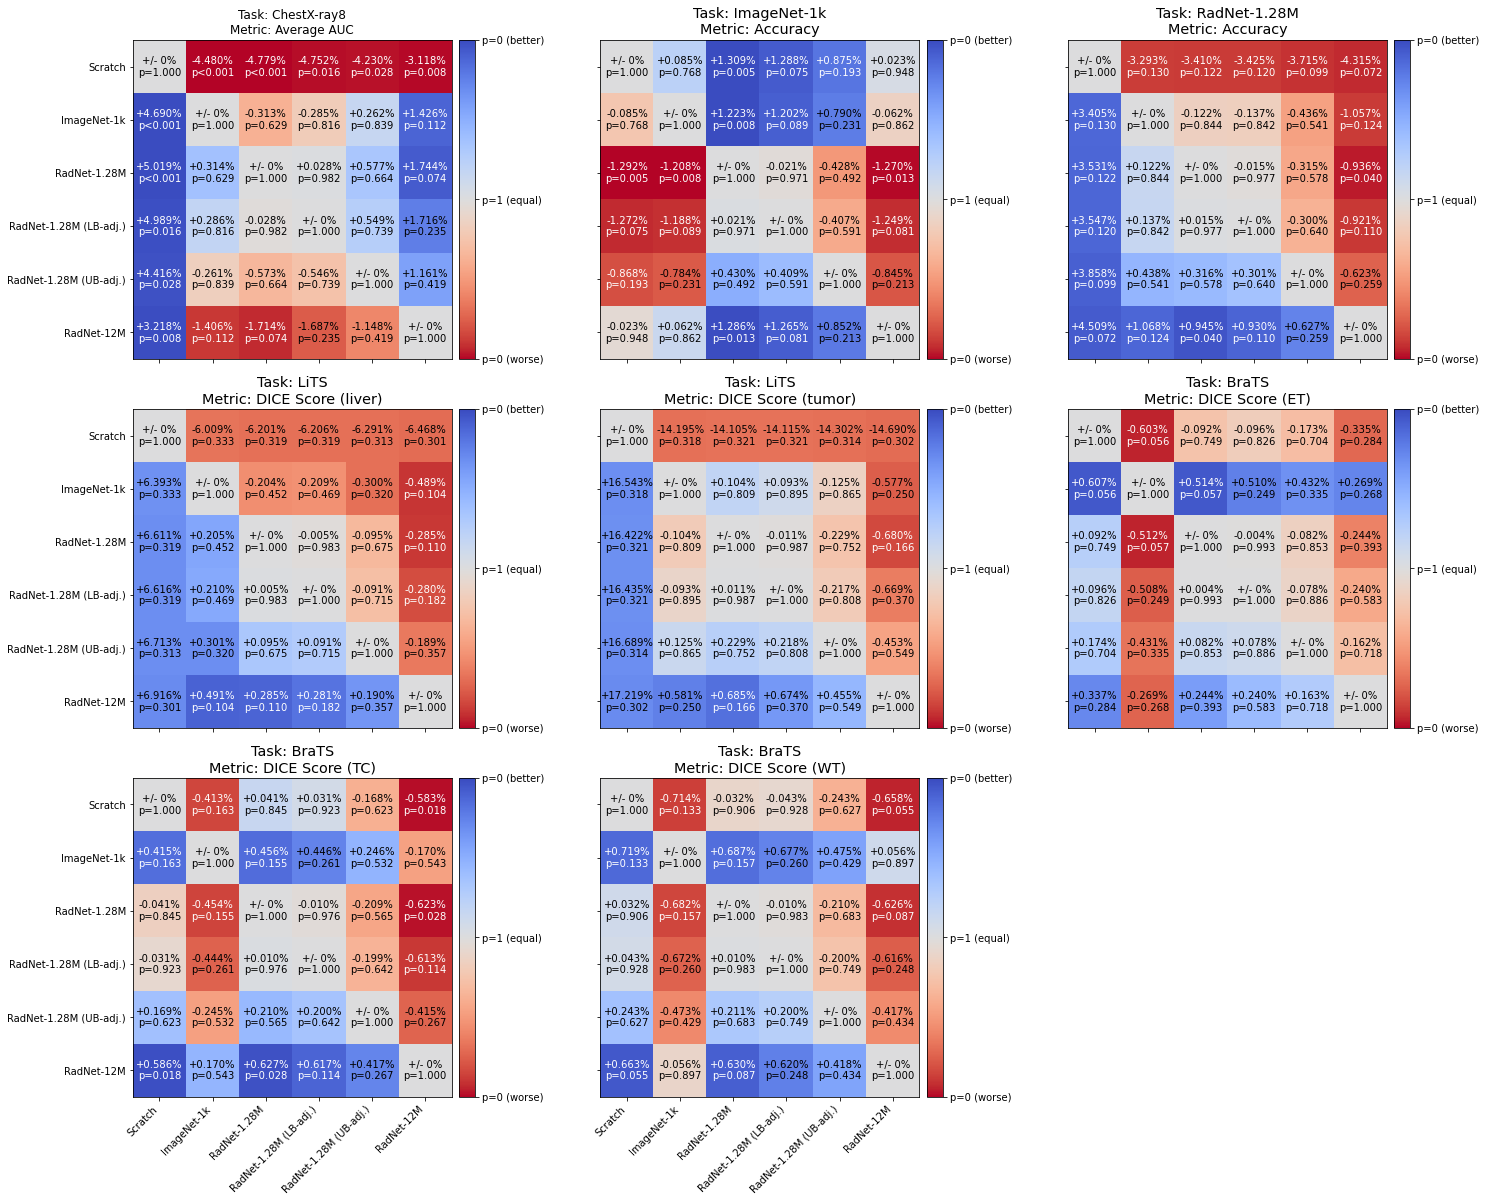

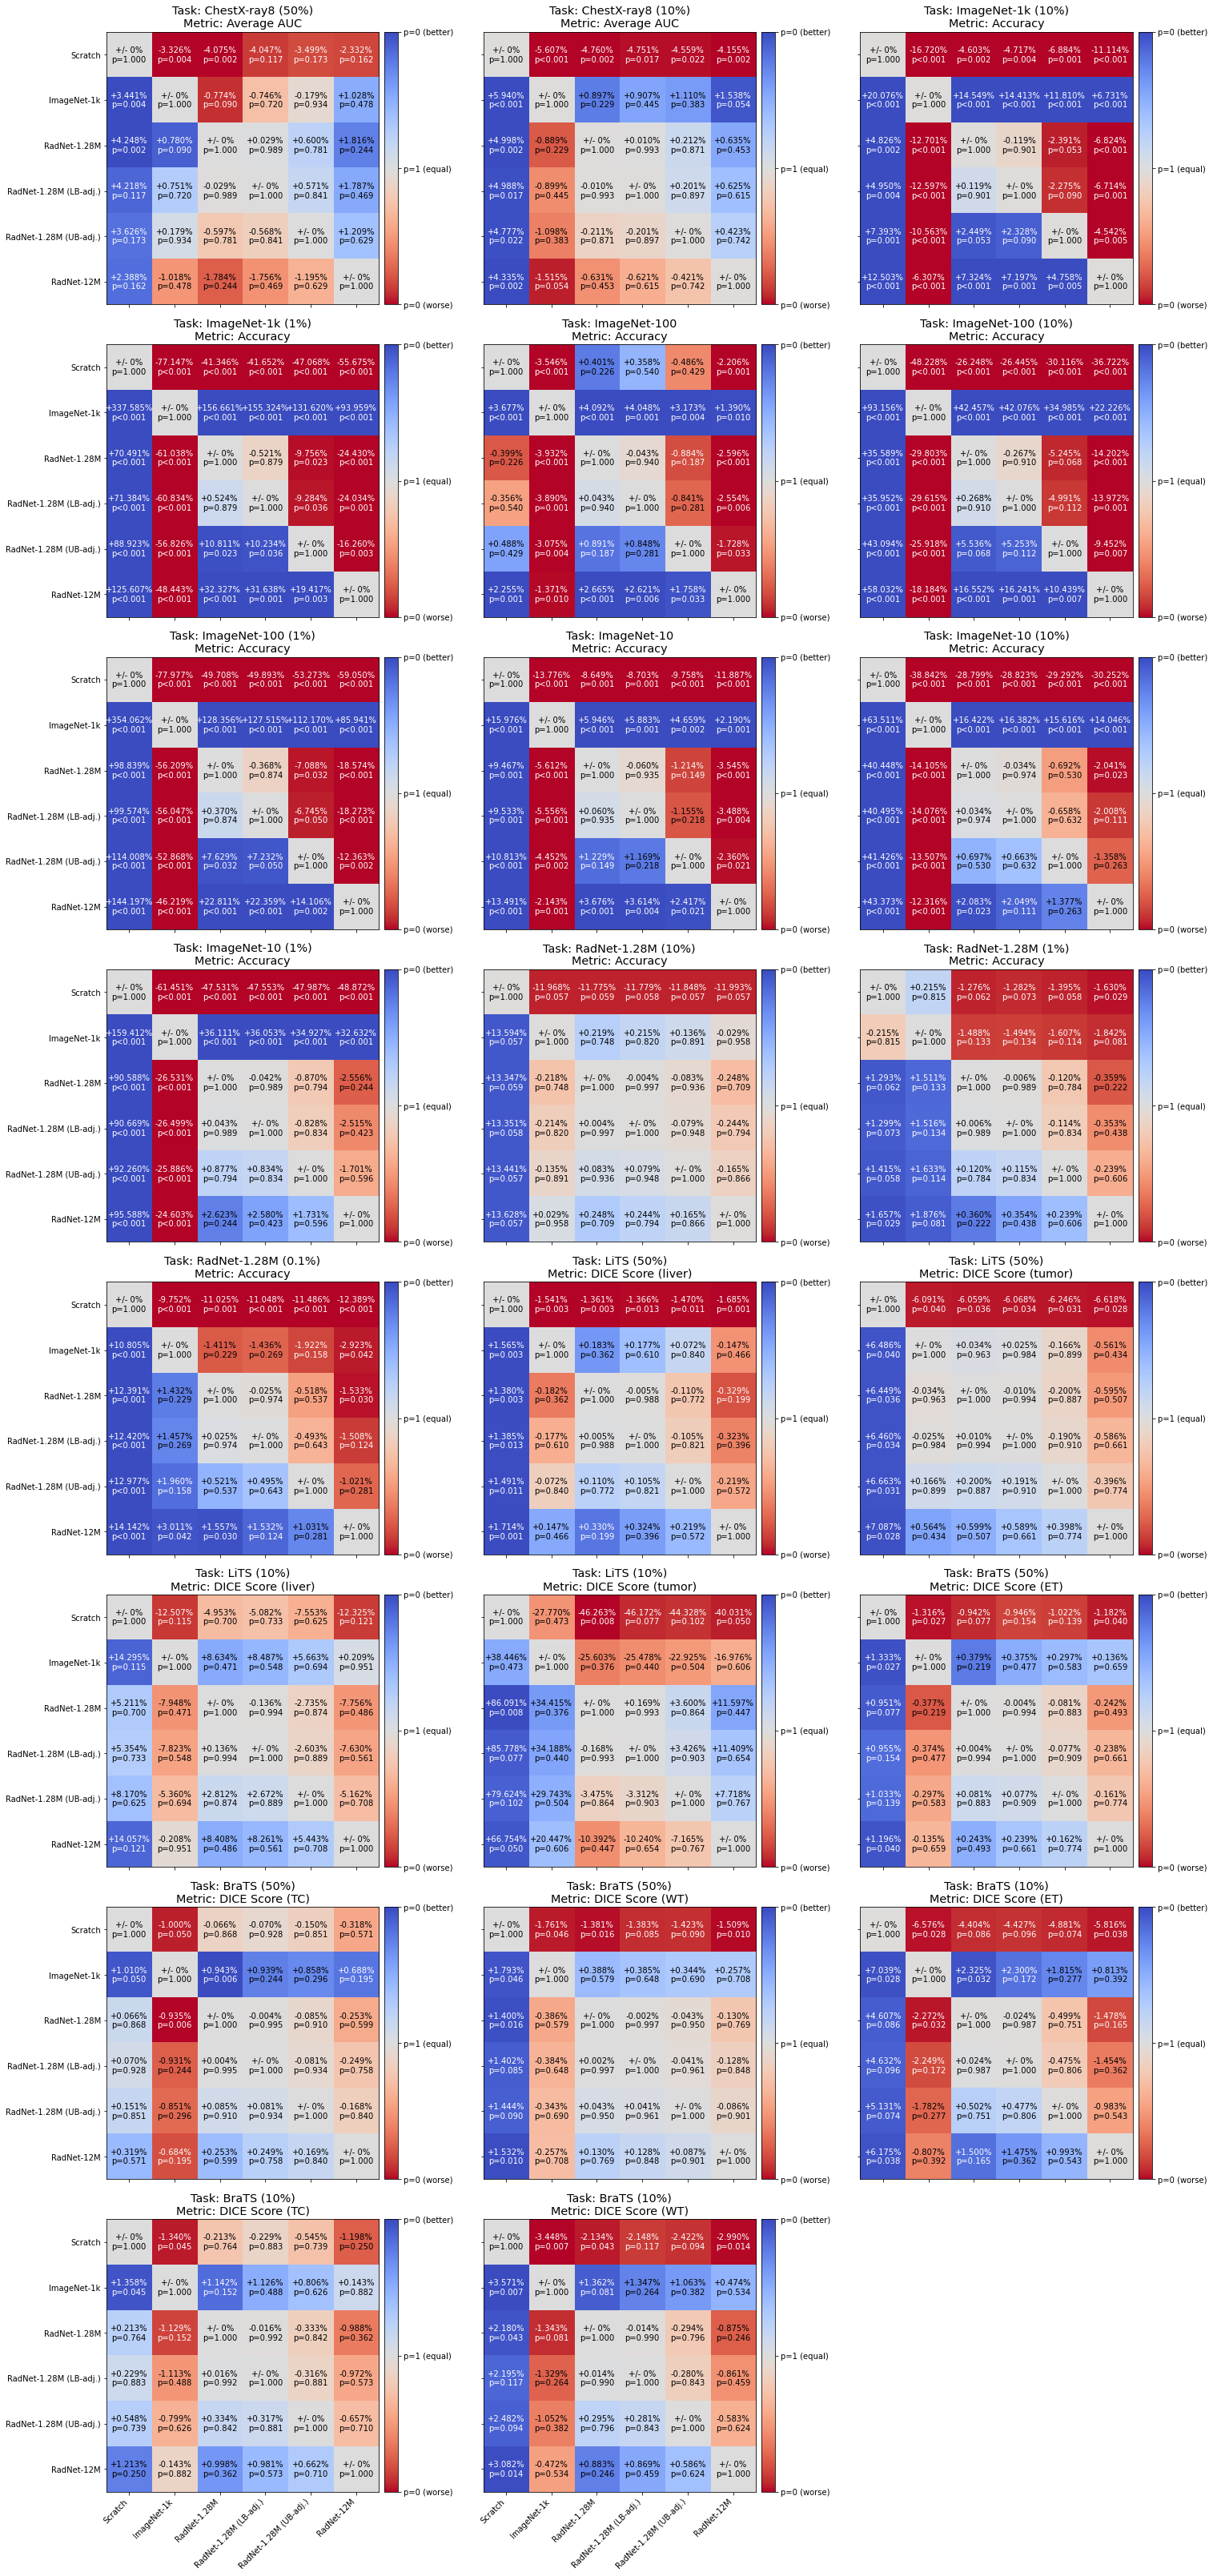

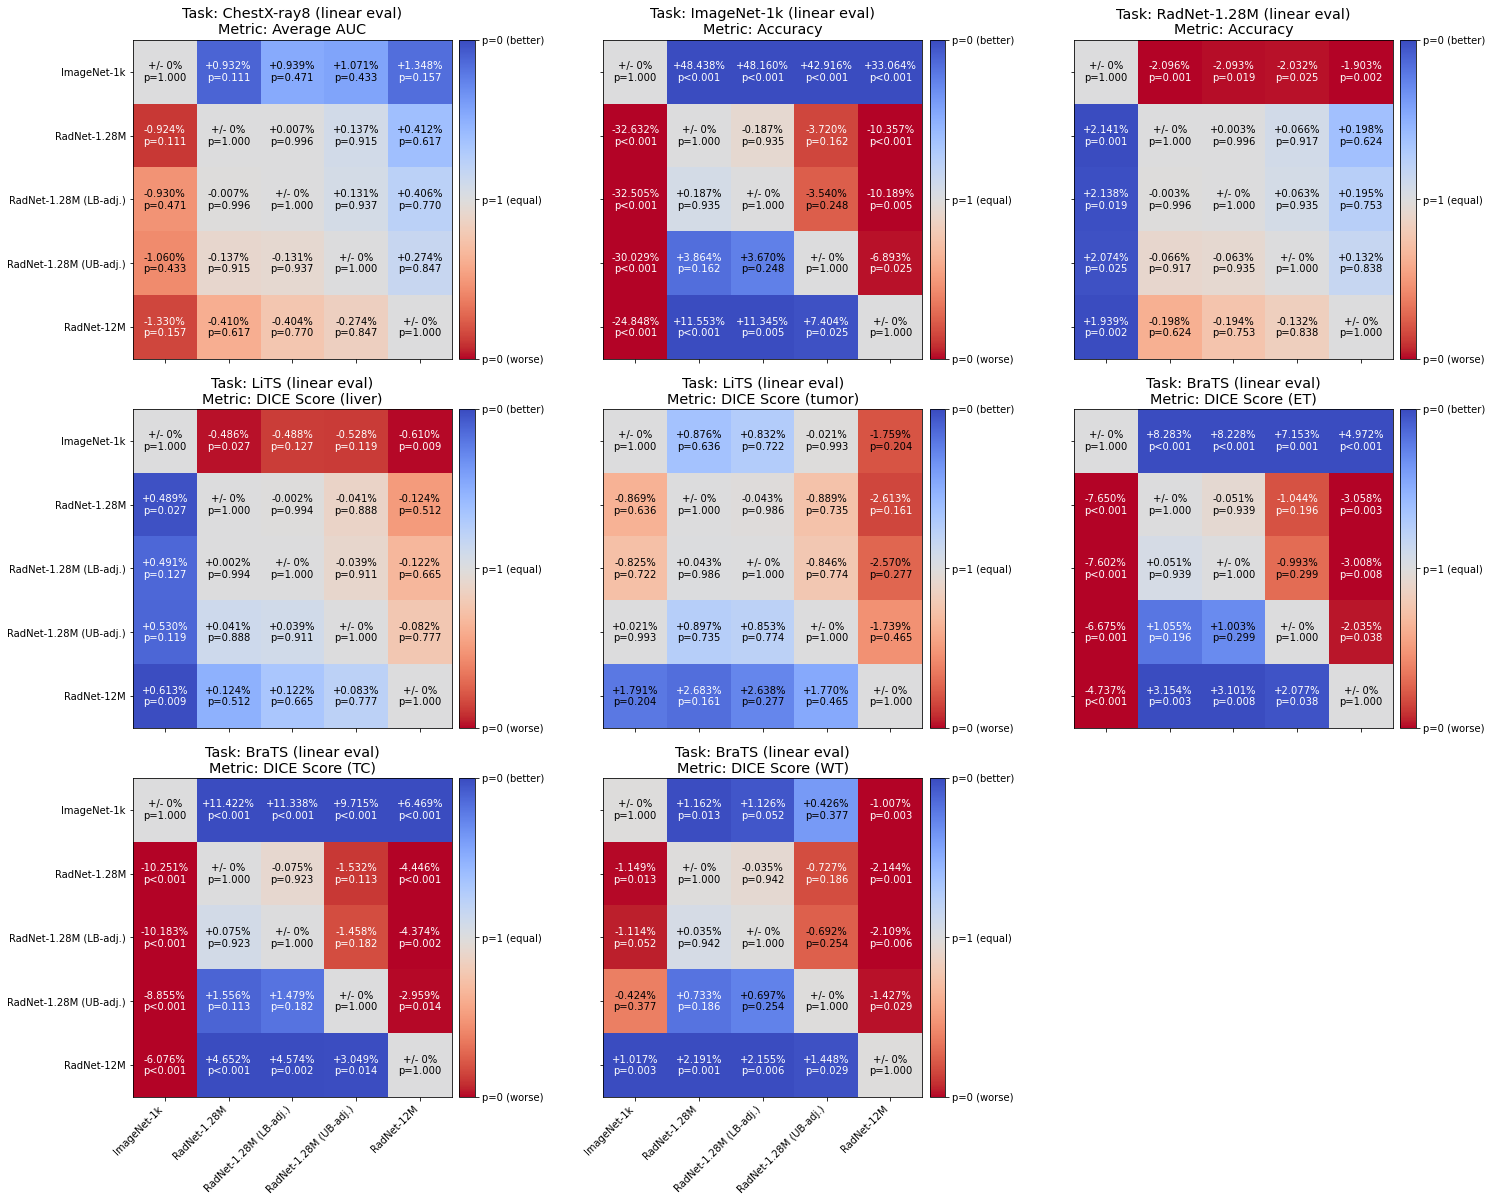

In [7]:
for e in es:
    if e == "E3": # E3 has no runs for uncertainty estimation
        continue
    else:
        ftmz = [(ft, m) for ft in fts[e] for m in comp_metrics[trunc(ft)]]
        cols = 3
        rows = len(ftmz)//cols +1
        fig, axes = plt.subplots(nrows = rows, ncols = cols, figsize = (7*cols, 5.6*rows), sharex = True, sharey = True)
        for i, (ft, m) in enumerate(ftmz):
            if "LiTS" in ft:
                ftsh = "LiTS"
            elif "BraTS" in ft:
                ftsh = "BraTS"
            else:
                ftsh = None
            ax = axes[i//cols, i%cols]
            ax.set_xticks([x for x in range(len(pts[e]))])
            ax.set_yticks([y for y in range(len(pts[e]))])
            ax.set_xticklabels([plot_names[p] if isinstance(plot_names[p], str) else plot_names[p][ftsh] for p in pts[e]])
            ax.set_yticklabels([plot_names[p] if isinstance(plot_names[p], str) else plot_names[p][ftsh] for p in pts[e]])
            ax.figure.autofmt_xdate(rotation=45)
            p_value_mat = pvms[(e, ft, m)]
            pci_mat = pcs[(e, ft, m)]
            visual_mat = ges[(e, ft, m)] * (1 - pvms[(e, ft, m)])
            im = ax.imshow(visual_mat, cmap = "coolwarm_r", vmin = -1, vmax = 1)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size = "5%", pad = 0.1)
            cbar = fig.colorbar(mappable = im, cax = cax)
            cbar.set_ticks([1, 0, -1])
            cbar.set_ticklabels(["p=0 (better)", "p=1 (equal)", "p=0 (worse)"])
            ax.set_title(f"Task: {plot_names[ft]}\nMetric: {plot_names[m] if isinstance(plot_names[m], str) else plot_names[m][ftsh]}")
            plt.rcParams.update({'axes.titlesize': 'x-large'})
            plt.rcParams.update({'axes.labelsize': 'large'})
            add_text_to_matrices(ax, pci_mat, p_value_mat)
            #ax.text(-0.1, 1.1, alphabet[i], transform = ax.transAxes, fontsize = 16, fontweight = 'bold', va = 'top', ha = 'right')
        for j in range(rows * cols - i):
            if j == 0:
                continue
            ax = axes[(i+j)//cols, (i+j)%cols]
            ax.set_visible(False)
        fig.subplots_adjust(hspace = 1.0, wspace = 1.0)
        fig.tight_layout()
        plt.savefig(f"./figures/Results_{e}.svg", format = "svg", bbox_inches = "tight")

In [8]:
def gather_for_barplot():
    
    barplot_means = {}
    barplot_stds = {}
    for e in es:
        if e == "E3": # E3 needs EE runs
            continue

        e_logs = sorted(get_logs_from_e(e))
        res = {}
        for log in e_logs:
            e, pt, ft = get_name(log, for_print = False)
            results = get_results_for_pvms(find_extra_runs(log))
            col_names = results.columns
            res[(e, pt, ft)] = {}
            for col_name in col_names:
                res[(e, pt, ft)][col_name] = results[col_name]

        for ft in fts[e]:
            for m in comp_metrics[trunc(ft)]:
                for pt in pts[e]:
                    pop = get_pop(res, e, pt, ft, m)
                    mean = np.mean(pop)
                    std = np.std(pop)
                    if (e, ft, m) not in barplot_means:
                        barplot_means[(e, ft, m)] = {}
                        barplot_stds[(e, ft, m)] = {}
                    barplot_means[(e, ft, m)][pt] = mean
                    barplot_stds[(e, ft, m)][pt] = std

    return barplot_means, barplot_stds

barplot_means, barplot_stds = gather_for_barplot()

100%|██████████| 60/60 [00:00<00:00, 26941.25it/s]


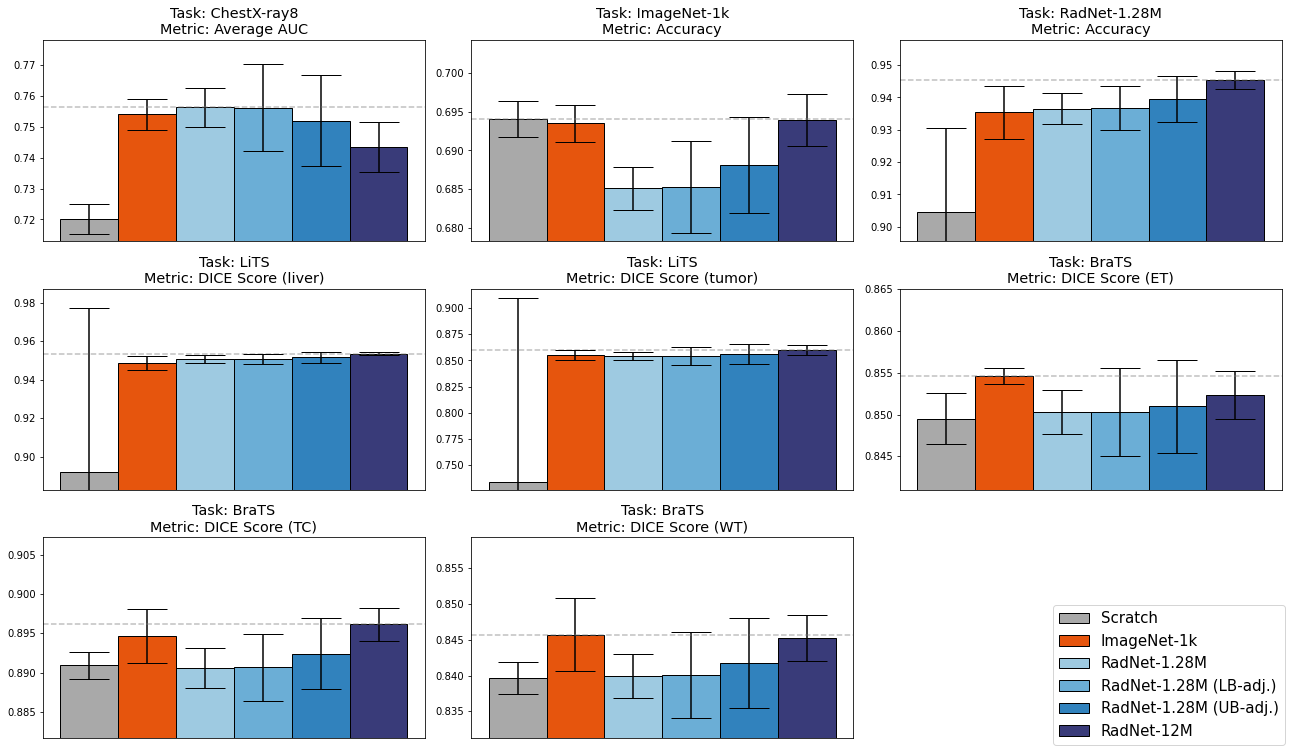

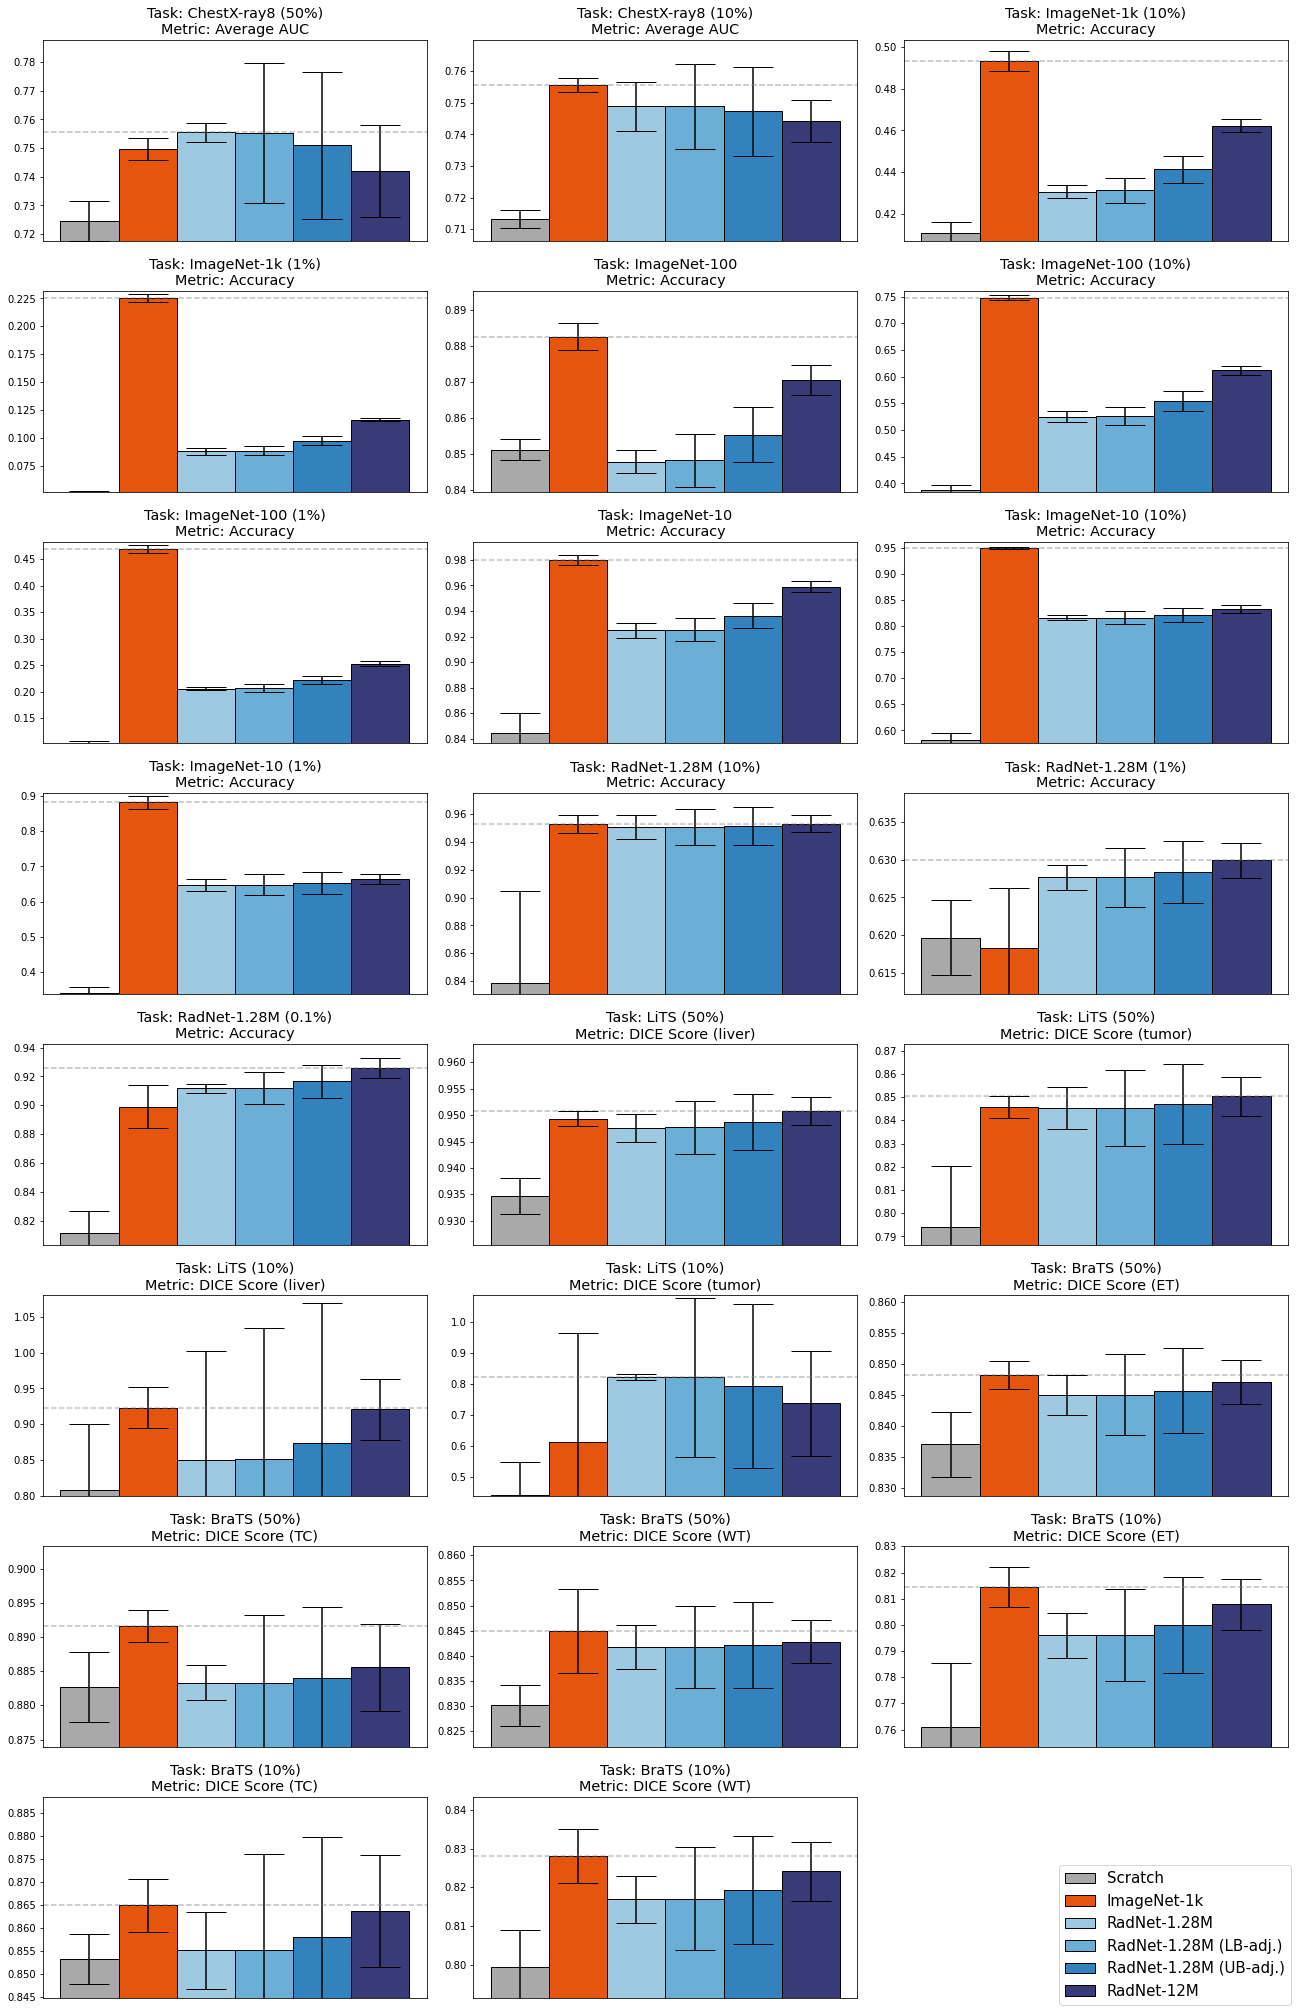

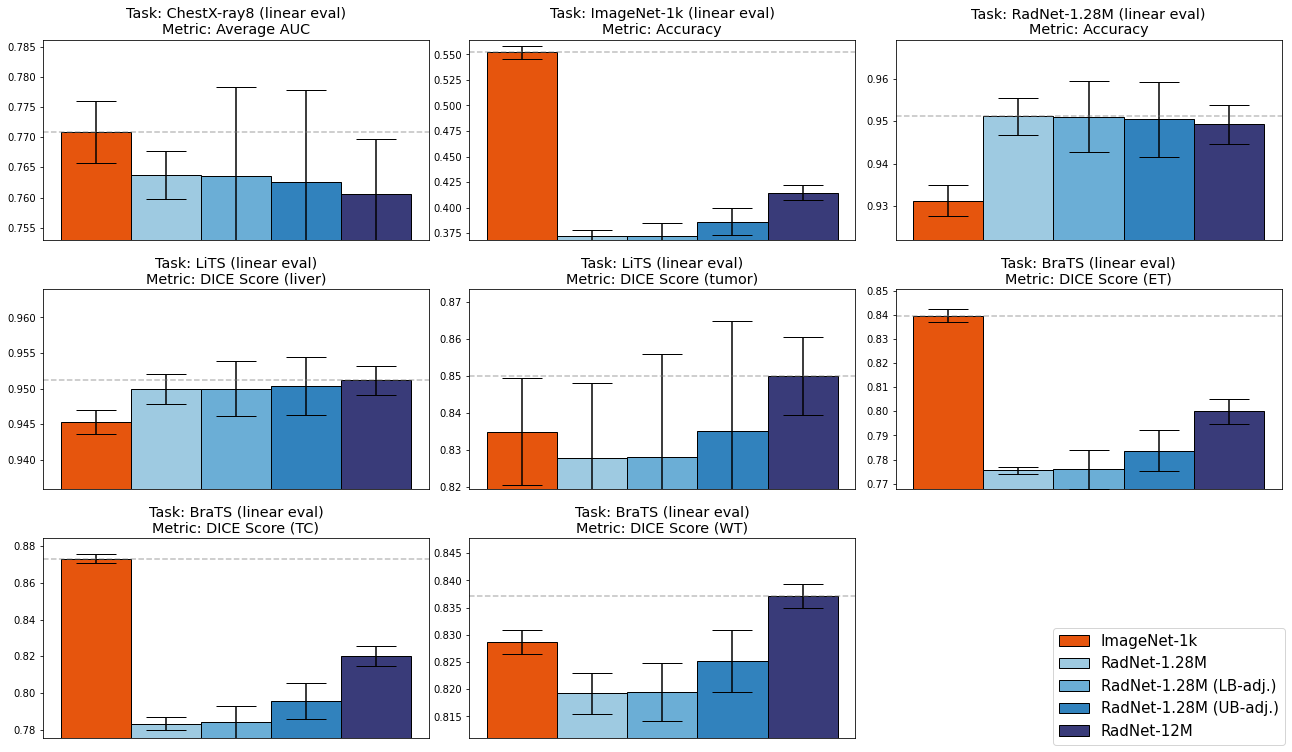

In [9]:
bpc_lc = {
    "Scratch": "darkgray", #plt.cm.tab20c(18),
    "I1k": plt.cm.tab20c(4),
    "R": plt.cm.tab20c(2),
    "RLB": plt.cm.tab20c(1),
    "RUB": plt.cm.tab20c(0),
    "RF": plt.cm.tab20b(0),
}

bpc_hc = {
    "Scratch": "magenta",
    "I1k": "red",
    "R": "sandybrown",
    "RLB": "gold",
    "RUB": "yellowgreen",
    "RF": "cornflowerblue",
}

for e in es:
    if e == "E3": # E3 has no runs for uncertainty estimation
        continue
    else:
        ftmz = [(ft, m) for ft in fts[e] for m in comp_metrics[trunc(ft)]]
        cols = 3
        rows = len(ftmz)//cols +1
        fig, axes = plt.subplots(nrows = rows, ncols = cols, figsize = (6*cols, 3.5*rows), sharex = False, sharey = False)
        for i, (ft, m) in enumerate(ftmz):
            if "LiTS" in ft:
                ftsh = "LiTS"
            elif "BraTS" in ft:
                ftsh = "BraTS"
            else:
                ftsh = None
            ax = axes[i//cols, i%cols]
            ax.set_xticks([x*0.5 for x in range(len(pts[e]))])
            ax.get_xaxis().set_visible(False)
            #ax.set_xticklabels([plot_names[p] if isinstance(plot_names[p], str) else plot_names[p][ftsh] for p in pts[e]])
            ax.tick_params(axis = 'both', which = 'both', labelbottom = True)
            ax.figure.autofmt_xdate(rotation = 45)
            ax.axhline(max([v for v in barplot_means[(e, ft, m)].values()]), linestyle = "--", c = "gray", alpha = 0.5)
            plt.rcParams.update({'axes.titlesize': 'x-large'})
            plt.rcParams.update({'axes.labelsize': 'large'})
            plt.rcParams.update({"errorbar.capsize": 20})
            for k, (pt, r) in enumerate(barplot_means[(e, ft, m)].items()):
                ax.bar(
                    k, 
                    barplot_means[(e, ft, m)][pt], 
                    yerr = barplot_stds[(e, ft, m)][pt], 
                    color = bpc_lc[pt], 
                    edgecolor = "k",
                    width = 1,
                    linewidth = 1,
                    label = plot_names[pt],
                    )
            y_range = [v1 for v1, v2 in zip(barplot_means[(e, ft, m)].values(), barplot_stds[(e, ft, m)].values())] # should be v1 - v2, but then you cant see small differences
            y_range.extend([v1 + v2 for v1, v2 in zip(barplot_means[(e, ft, m)].values(), barplot_stds[(e, ft, m)].values())])
            ax.set_ylim(0.99 * min(y_range), 1.01 * max(y_range))
            ax.set_title(f"Task: {plot_names[ft]}\nMetric: {plot_names[m] if isinstance(plot_names[m], str) else plot_names[m][ftsh]}")
            #ax.text(-0.1, 1.15, alphabet[i], transform = ax.transAxes, fontsize = 16, fontweight = 'bold', va = 'top', ha = 'right')
        for j in range(rows * cols - i):
            if j == 0:
                continue
            ax = axes[(i+j)//cols, (i+j)%cols]
            ax.set_visible(False)
        handles, labels = axes[0, 0].get_legend_handles_labels()
        legend = fig.legend(handles, labels, loc = 'lower right', prop = {'size': 15})
        fig.subplots_adjust(hspace = 1.0, wspace = 1.0)
        fig.tight_layout()
        # Save full plot
        plt.savefig(f"./figures/Results_{e}_bars.svg", format = "svg", bbox_inches = "tight")
        # Save just the legend
        fig  = legend.figure
        fig.canvas.draw()
        bbox  = legend.get_window_extent()
        bbox = bbox.from_extents(*(bbox.extents + np.array([-5, -5, 5, 5])))
        bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(f"./figures/Results_{e}_bars_legend.svg", format = "svg", dpi = "figure", bbox_inches = bbox)

<ipython-input-10-0eea38936528>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, plt.figure(figsize = (6, 3.5))


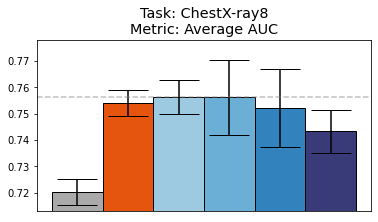

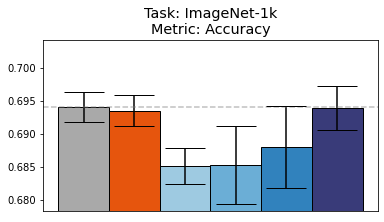

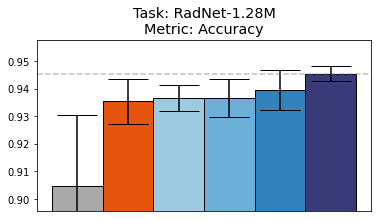

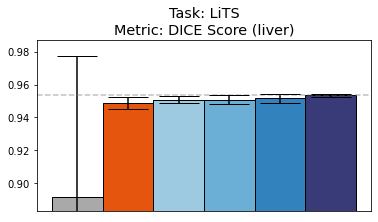

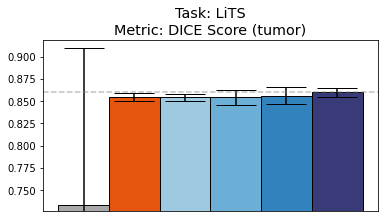

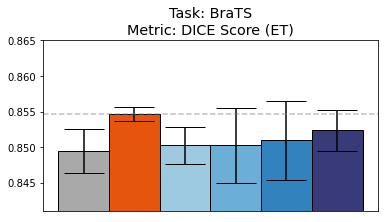

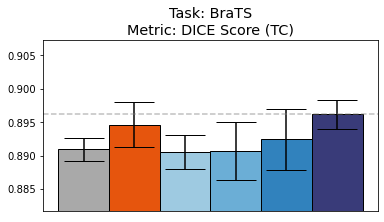

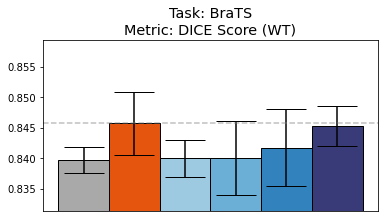

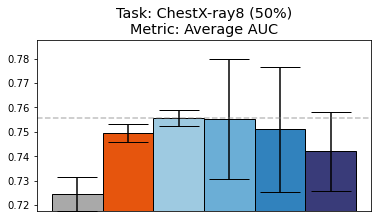

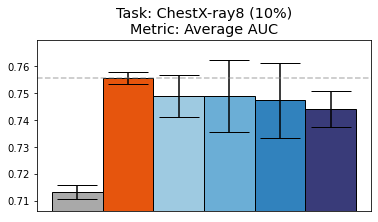

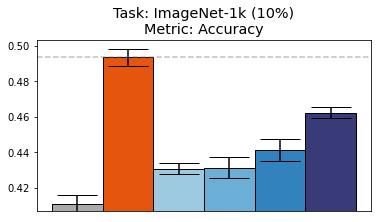

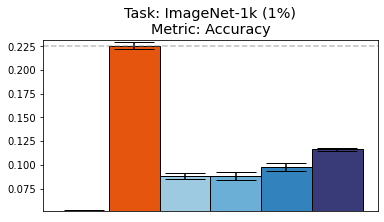

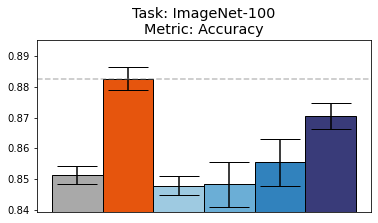

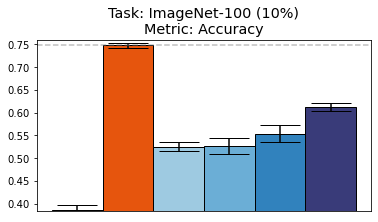

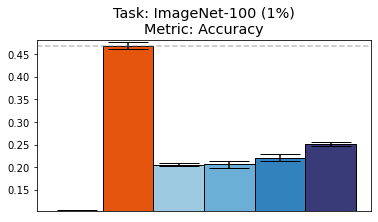

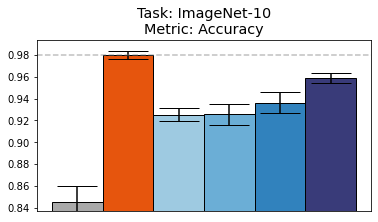

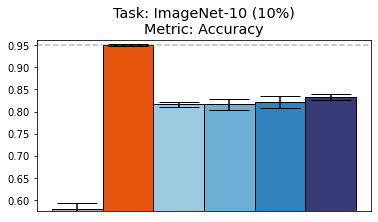

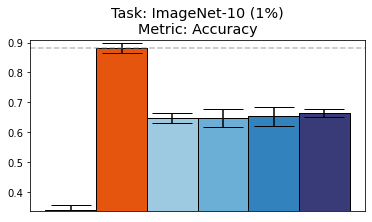

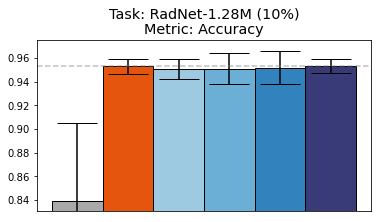

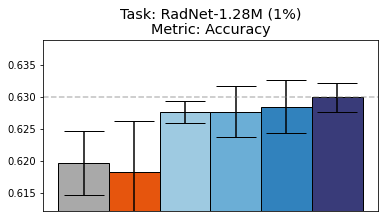

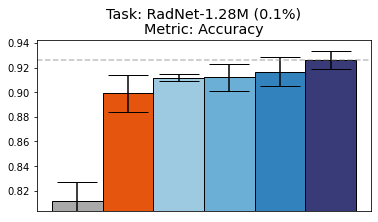

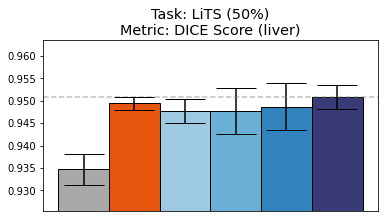

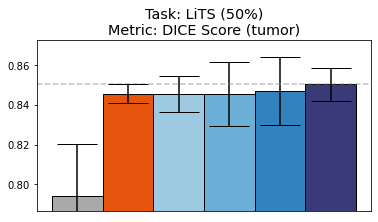

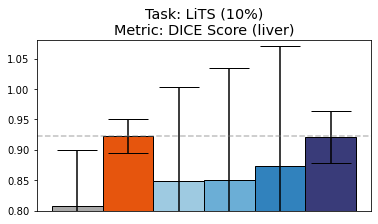

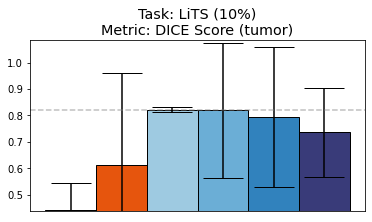

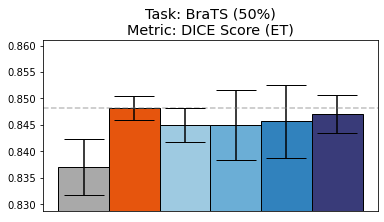

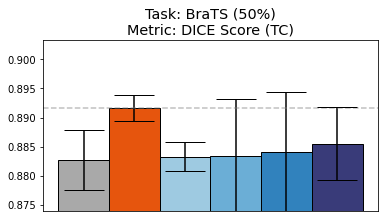

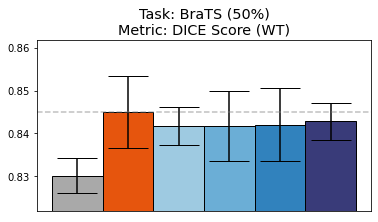

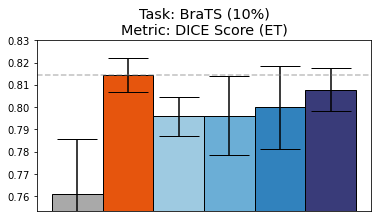

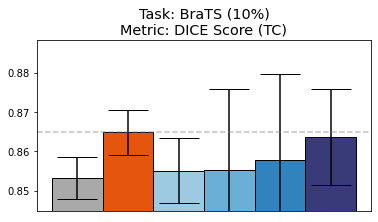

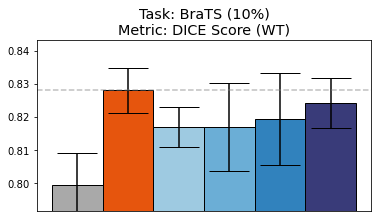

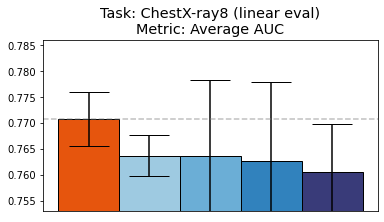

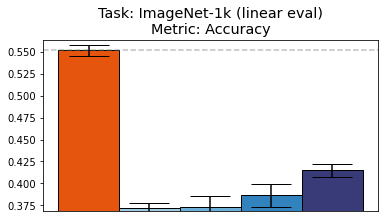

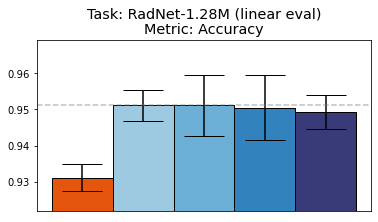

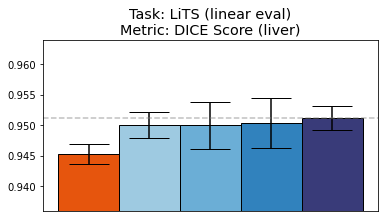

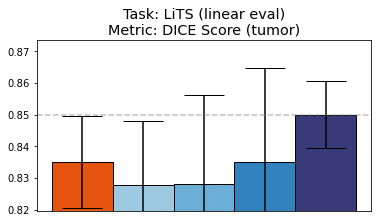

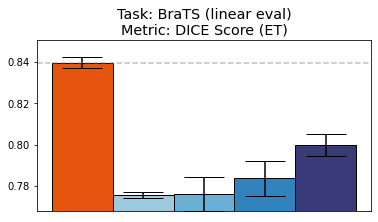

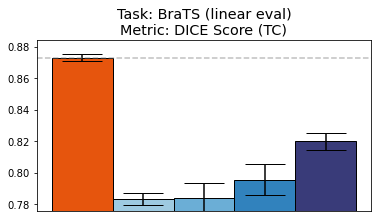

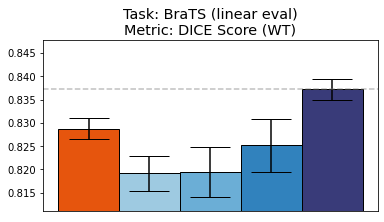

In [10]:
for e in es:
    if e == "E3": # E3 has no runs for uncertainty estimation
        continue
    else:
        ftmz = [(ft, m) for ft in fts[e] for m in comp_metrics[trunc(ft)]]
        for fn, m in ftmz:
            fig, plt.figure(figsize = (6, 3.5))
            ax = plt.gca()
            plt.rcParams.update({'axes.titlesize': 'x-large'})
            plt.rcParams.update({'axes.labelsize': 'large'})
            plt.rcParams.update({"errorbar.capsize": 20})
            for (cfn, cm) in ftmz:
                if "LiTS" in cfn:
                    ftsh = "LiTS"
                elif "BraTS" in cfn:
                    ftsh = "BraTS"
                else:
                    ftsh = None
                if fn != cfn or cm != m:
                    continue
                ax.set_xticks([x*0.5 for x in range(len(pts[e]))])
                ax.get_xaxis().set_visible(False)
                ax.tick_params(axis = 'both', which = 'both', labelbottom = True)
                ax.figure.autofmt_xdate(rotation = 45)
                ax.axhline(max([v for v in barplot_means[(e, cfn, cm)].values()]), linestyle = "--", c = "gray", alpha = 0.5)
                for k, (cpn, r) in enumerate(barplot_means[(e, cfn, cm)].items()):
                    ax.bar(
                        k, 
                        barplot_means[(e, cfn, cm)][cpn], 
                        yerr = barplot_stds[(e, cfn, cm)][cpn], 
                        color = bpc_lc[cpn], 
                        edgecolor = "k",
                        width = 1,
                        linewidth = 1,
                        label = plot_names[cpn],
                        )
                y_range = [v1 for v1, v2 in zip(barplot_means[(e, cfn, cm)].values(), barplot_stds[(e, cfn, cm)].values())] # should be v1 - v2, but then you cant see small differences
                y_range.extend([v1 + v2 for v1, v2 in zip(barplot_means[(e, cfn, cm)].values(), barplot_stds[(e, cfn, cm)].values())])
                ax.set_title(f"Task: {plot_names[fn]}\nMetric: {plot_names[cm] if isinstance(plot_names[cm], str) else plot_names[cm][ftsh]}")
            ax.set_ylim(0.99 * min(y_range), 1.01 * max(y_range))
            fig.tight_layout()
            # Save single plot
            plt.savefig(f"./figures/Results_{e}_{fn}_{m}_bars.svg", format = "svg", bbox_inches = "tight")